In [18]:
import os
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and

/tmp/ipykernel_28585/4172713895.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


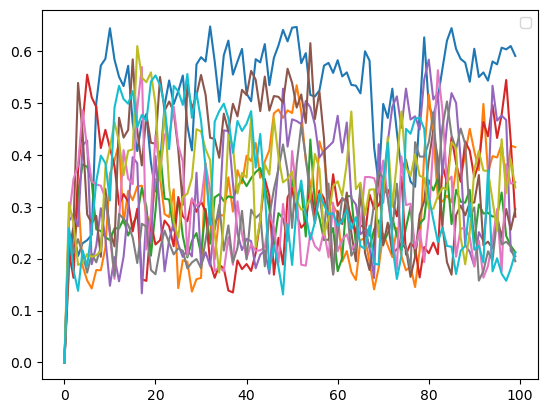

In [ ]:
def analysis(traj_files, top_file, slice_step=1):
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)[::slice_step]
        traj.image_molecules(inplace=True)
        protein_atoms = traj.topology.select('protein and name CA')
        traj.superpose(traj, frame=0, atom_indices=protein_atoms)
        ligand_atoms = traj.topology.select('resname UNK')
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        plt.plot(ligand_rmsd)
        #plt.show()
        #plt.close()
        traj.save(f'rep{i}_processed.xtc')

for i in range(10):
    analysis(['rep_' + str(i) + '/trj.dcd'], 'minimized_system.pdb')
plt.legend()
plt.show()

In [11]:
rmsd_min = 0.0
rmsd_max = 1.0
num_grid_points = 2500
rmsd_axis = np.linspace(rmsd_min, rmsd_max, num_grid_points)

/tmp/ipykernel_85120/2658355871.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


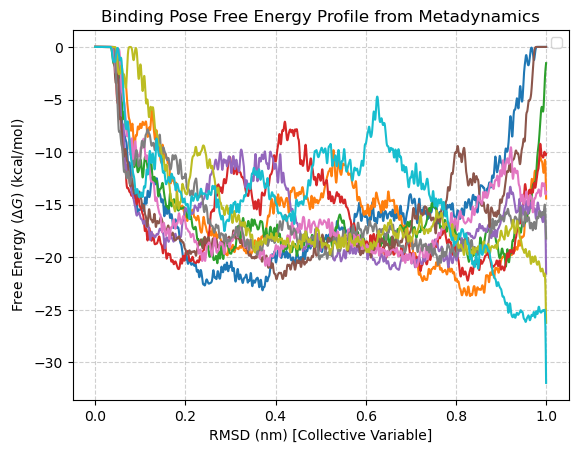

In [12]:
import glob

pmf_df = None
for i in range(10):
    files = glob.glob(os.path.join(f'rep_{i}', 'bias_*.npy'))
    bias = np.load(files[0]).squeeze()
    estimated_fep = -bias
    plt.plot(rmsd_axis, estimated_fep)
    plt.xlabel('RMSD (nm) [Collective Variable]')
    plt.ylabel('Free Energy ($\Delta G$) (kcal/mol)')
    plt.title('Binding Pose Free Energy Profile from Metadynamics')
    plt.grid(True, linestyle='--', alpha=0.6)
    
plt.legend()
plt.show()

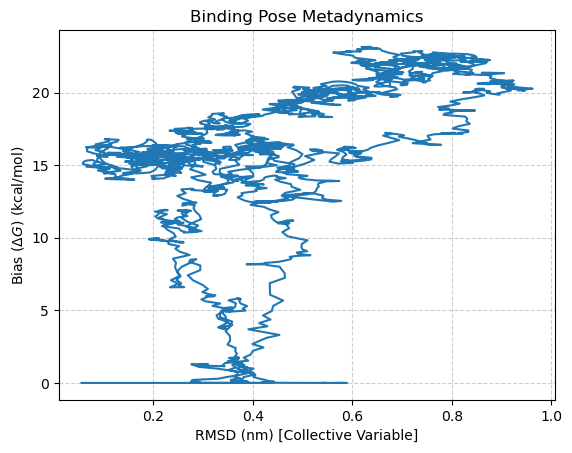

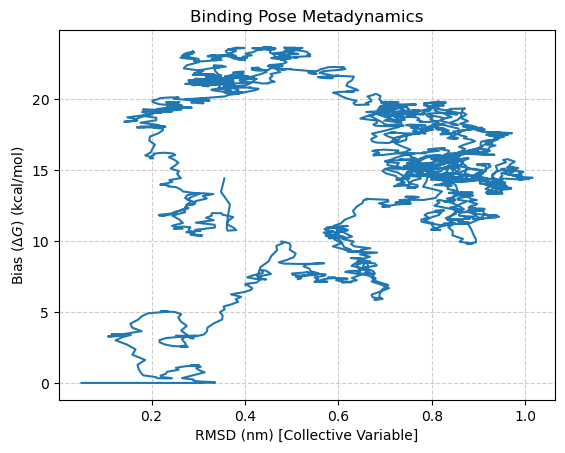

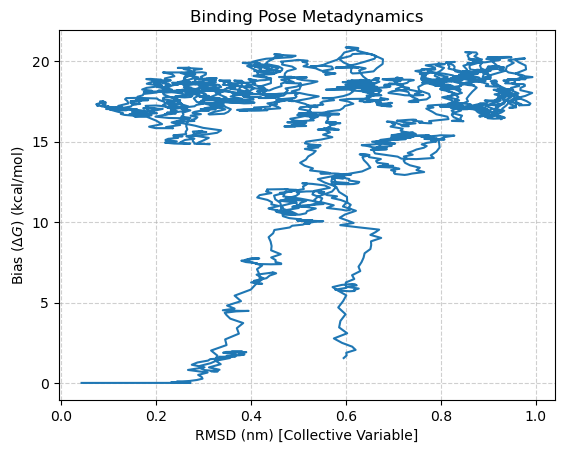

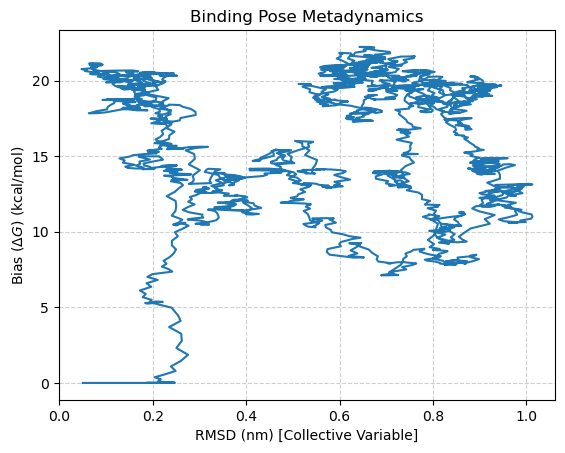

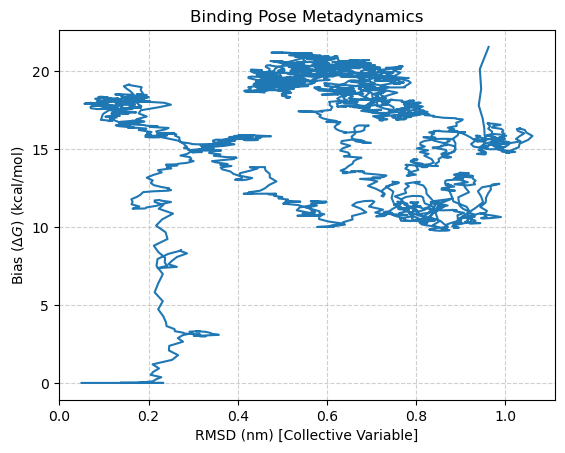

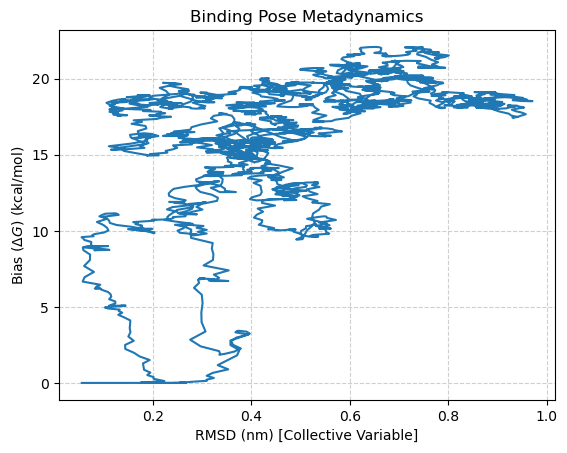

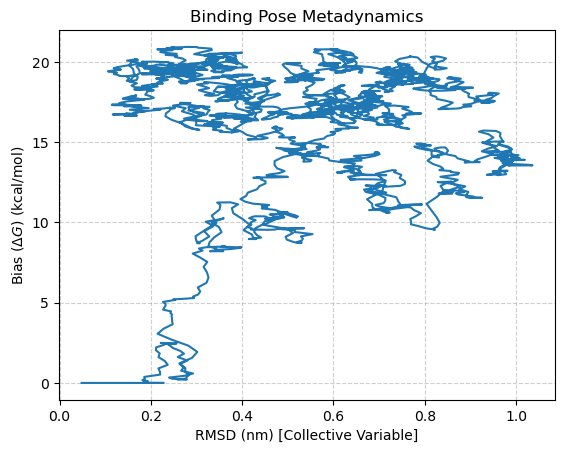

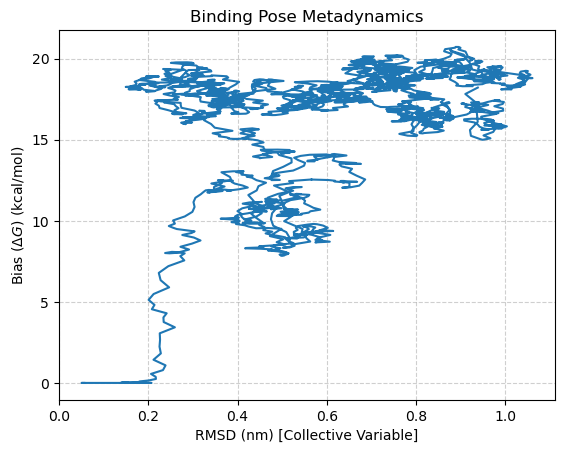

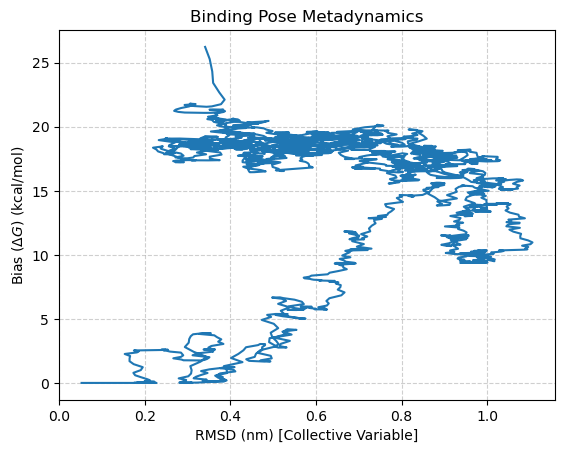

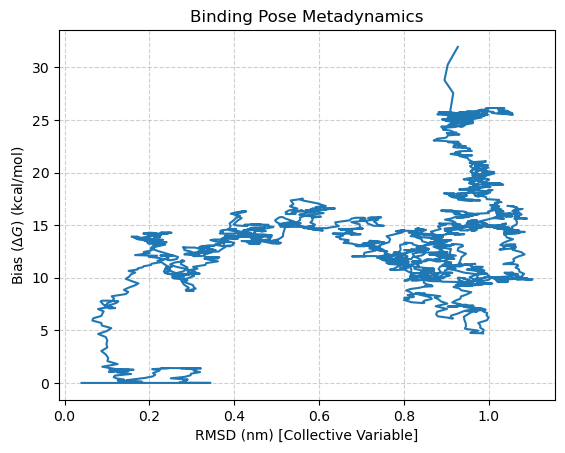

In [20]:
import glob

pmf_df = None
for i in range(10):
    files = glob.glob(os.path.join(f'rep_{i}', 'bias_*.npy'))
    bias = np.load(files[0]).squeeze()
    cv_files = glob.glob(os.path.join(f'rep_{i}', 'COLVAR.npy'))
    cv_values = np.load(cv_files[0]).squeeze()[1::2]
    plt.plot(cv_values, bias)
    plt.xlabel('RMSD (nm) [Collective Variable]')
    plt.ylabel('Bias ($\Delta G$) (kcal/mol)')
    plt.title('Binding Pose Metadynamics')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
#plt.legend()
#plt.show()

/tmp/ipykernel_85120/2957374884.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


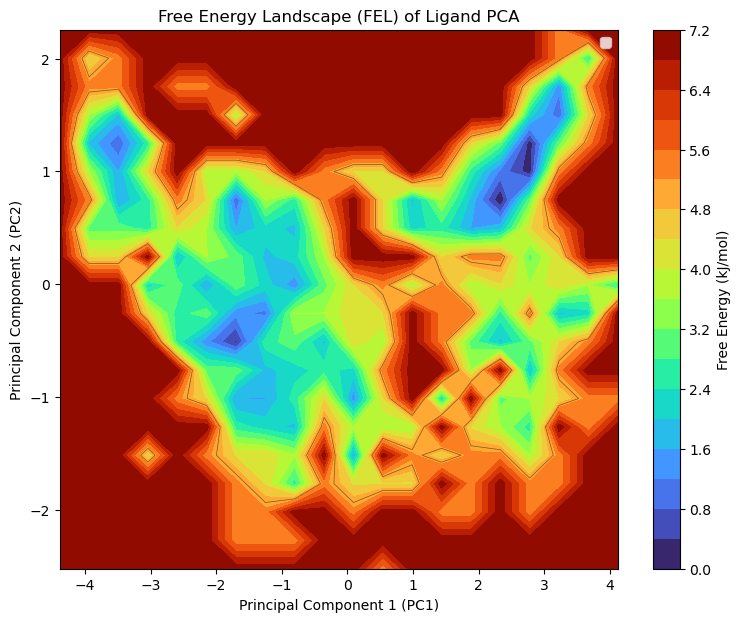

In [19]:
def plot_ligand_fel(traj_files, top_file, grid_bins=20, T=300, unit='kJ/mol', slice_step=1):

    traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]
    for i, traj_file in enumerate(traj_files[1:]):
        traj = md.load(traj_file, top=top_file)[::slice_step]
        traj_cont = md.join([traj_cont, traj])

    traj_cont.image_molecules(inplace=True)
    protein_atoms = traj_cont.topology.select('protein and name CA')
    traj_cont.superpose(traj_cont, frame=0, atom_indices=protein_atoms)

    n_frames = traj_cont.n_frames
    original_indices = np.arange(0, n_frames * slice_step, slice_step)

    ligand_atoms = traj_cont.topology.select('resname UNK')
    if not ligand_atoms.size:
        raise ValueError("Ligand 'UNK' not found. Check the residue name.")
        
    ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
    ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
    pca1 = PCA(n_components=2)
    reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
    
    PC1 = reduced_cartesian[:, 0]
    PC2 = reduced_cartesian[:, 1]

    data_map = np.column_stack((PC1, PC2, original_indices))
    
    hist, xedges, yedges = np.histogram2d(
        PC1, 
        PC2, 
        bins=grid_bins, 
        density=True
    )

    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    
    P = hist.T  # Transpose the probability matrix for correct plotting orientation

    # Define Boltzmann constants
    R = 8.314462618  # J/(mol*K)
    
    if unit == 'kJ/mol':
        R_unit = R / 1000.0 
    elif unit == 'kcal/mol':
        R_unit = R / 4184.0 
    else:
        raise ValueError("Unit must be 'kJ/mol' or 'kcal/mol'.")
        
    P_min_nonzero = P[P > 0].min()
    P_corrected = np.where(P > 0, P, P_min_nonzero)
    
    G = -R_unit * T * np.log(P_corrected)
    G_min = G.min()
    G_shifted = G - G_min

    plt.figure(figsize=(9, 7))

    plt.contour(
        xcenters, 
        ycenters, 
        G_shifted, 
        levels=np.arange(0, G_shifted.max(), 5), # E.g., lines every 5 units
        colors='black', 
        linewidths=0.5, 
        alpha=0.5
    )
    
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.title(f'Free Energy Landscape (FEL) of Ligand PCA')
    
    # Add color bar
    contour = plt.contourf(
        xcenters, 
        ycenters, 
        G_shifted, 
        levels=20, # Number of energy levels to plot
        cmap="turbo"
    )
    plt.colorbar(contour, label=f'Free Energy ({unit})')

    plt.legend()
    plt.show()
    plt.close()
    
    return data_map, hist, xedges, yedges

data_map, hist, xedges, yedges = plot_ligand_fel([f'rep{i}_processed.xtc' for i in range(10)], 'centred_equil_system.pdb', grid_bins=20, T=300, unit='kJ/mol', slice_step=1)